## Chapter 7. Nonlinear Regression Models

In [1]:
import os
import pyreadr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
pd.set_option('mode.chained_assignment',None)
os.environ["PYTHONWARNINGS"] = "ignore::UserWarning"

In [2]:
plt.rcParams['figure.figsize'] = 10, 7.5
plt.rcParams['axes.grid'] = True
plt.gray()

<Figure size 1000x750 with 0 Axes>

In [3]:
#base = importr('base')
#set_seed = robjects.r("set.seed")
#APM = importr('AppliedPredictiveModeling')
APMdatafolder = os.path.expanduser("~/Documents/dataset/AppliedPredictiveModeling/data")
os.path.isdir(APMdatafolder)

True

In [4]:
data_filename='solubility.RData'
file_path = os.path.join(APMdatafolder, data_filename)
datadict = pyreadr.read_r(file_path)

In [5]:
solTestX, solTestXtrans, solTestY, solTrainX, solTrainXtrans, solTrainY \
= datadict['solTestX'], datadict['solTestXtrans'], datadict['solTestY'], datadict['solTrainX'], datadict['solTrainXtrans'], datadict['solTrainY']

In [6]:
trainX, trainY = solTrainXtrans, solTrainY
testX, testY = solTestXtrans, solTestY

### 1. Multivariate Adaptive Regression Splines

In [7]:
from pyearth import Earth

In [8]:
criteria = ('rss', 'gcv', 'nb_subsets')
mars = Earth(feature_importance_type=criteria)
mars.fit(trainX,trainY)

Earth(feature_importance_type=('rss', 'gcv', 'nb_subsets'))

In [9]:
print(mars.summary())

Earth Model
--------------------------------------------------
Basis Function               Pruned  Coefficient  
--------------------------------------------------
(Intercept)                  No      4.60426      
h(MolWeight-5.90236)         No      -3.77976     
h(5.90236-MolWeight)         No      1.11329      
h(SurfaceArea1-13.4174)      No      0.591609     
h(13.4174-SurfaceArea1)      No      -0.270523    
NumNonHAtoms                 No      -2.93918     
FP142                        No      0.865185     
FP074                        No      0.402213     
FP206                        No      -0.858274    
FP135                        No      0.572875     
h(NumMultBonds-5.78614)      Yes     None         
h(5.78614-NumMultBonds)      No      0.191872     
FP164                        No      0.710663     
FP172                        No      -0.573536    
h(NumAromaticBonds-2.94444)  No      -5.86846     
h(2.94444-NumAromaticBonds)  Yes     None         
-------------------

In [10]:
print(mars.summary_feature_importances('rss'))

                      rss    gcv    nb_subsets
SurfaceArea1          0.48   0.49   0.14          
NumNonHAtoms          0.39   0.39   0.07          
FP142                 0.05   0.05   0.07          
MolWeight             0.03   0.03   0.14          
NumMultBonds          0.02   0.01   0.07          
FP206                 0.01   0.01   0.07          
FP172                 0.01   0.01   0.07          
FP074                 0.01   0.01   0.07          
NumAromaticBonds      0.01   0.00   0.14          
FP135                 0.01   0.01   0.07          
FP164                 0.00   0.00   0.07          
FP100                 0.00   0.00   0.00          
FP068                 0.00   0.00   0.00          
FP078                 0.00   0.00   0.00          
FP077                 0.00   0.00   0.00          
FP076                 0.00   0.00   0.00          
FP075                 0.00   0.00   0.00          
FP106                 0.00   0.00   0.00          
FP073                 0.00   0.00  

Text(0, 0.5, 'Log Solubility')

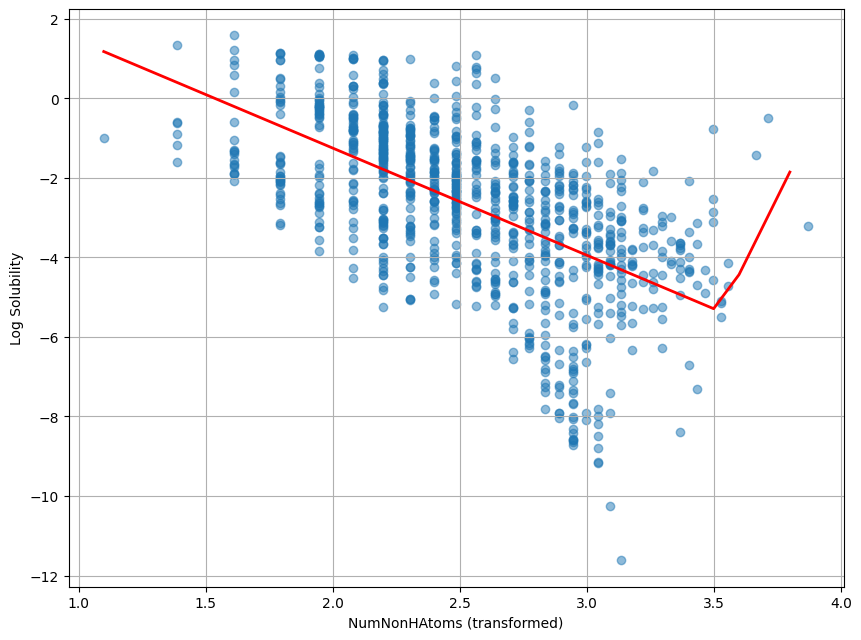

In [11]:
featureName = 'NumNonHAtoms'
mars = Earth()
mars.fit(trainX[[featureName]], trainY)

c_trainX = np.arange(np.min(trainX[featureName]), np.max(trainX[featureName]), 0.1)
mars_predict = mars.predict(c_trainX.reshape(-1,1))

plt.scatter(trainX[featureName], trainY, alpha=0.5)
plt.plot(c_trainX, mars_predict, 'r', linewidth=2)
plt.xlabel(featureName+' (transformed)')
plt.ylabel('Log Solubility')

### 2. Support Vector Machines

In [12]:
from sklearn.svm import SVR

In [13]:
opt_sigma = 0.0039

svr = SVR(kernel='rbf', gamma=opt_sigma, epsilon=0.1)
svr_params = {
    'C': np.logspace(-2, 11, num=14, base=2),
}
print(svr_params)

{'C': array([2.500e-01, 5.000e-01, 1.000e+00, 2.000e+00, 4.000e+00, 8.000e+00,
       1.600e+01, 3.200e+01, 6.400e+01, 1.280e+02, 2.560e+02, 5.120e+02,
       1.024e+03, 2.048e+03])}


In [14]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import ShuffleSplit

cv = ShuffleSplit(n_splits = 10, test_size = 0.1, random_state=3)

gs_svr = GridSearchCV(svr, svr_params, cv=cv, scoring="neg_mean_squared_error", n_jobs=-1)
gs_svr.fit(trainX, trainY['solTrainY'])

GridSearchCV(cv=ShuffleSplit(n_splits=10, random_state=3, test_size=0.1, train_size=None),
             estimator=SVR(gamma=0.0039), n_jobs=-1,
             param_grid={'C': array([2.500e-01, 5.000e-01, 1.000e+00, 2.000e+00, 4.000e+00, 8.000e+00,
       1.600e+01, 3.200e+01, 6.400e+01, 1.280e+02, 2.560e+02, 5.120e+02,
       1.024e+03, 2.048e+03])},
             scoring='neg_mean_squared_error')

Text(0, 0.5, 'RMSE (Cross-Validation)')

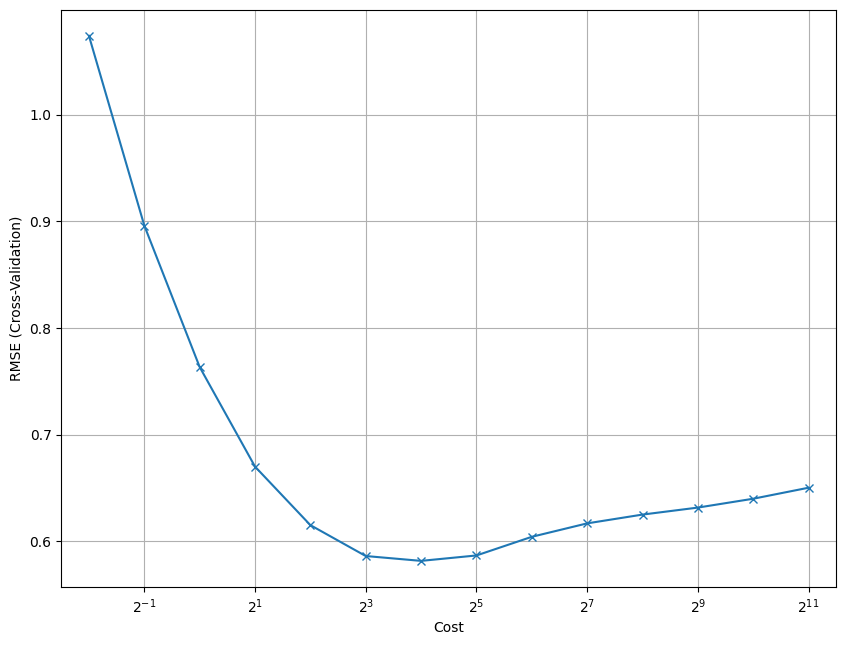

In [15]:
gs_grid_rmse = np.sqrt(-gs_svr.cv_results_['mean_test_score'])

plt.plot(np.logspace(-2, 11, num=14, base=2), gs_grid_rmse, '-x')
plt.xscale('log', base=2)
plt.xlim(2**-2.5, 2**11.5)
plt.xlabel('Cost')
plt.ylabel('RMSE (Cross-Validation)')

In [16]:
print(f"Best cost value associated with the smallest RMSE was {gs_svr.best_params_['C']}")

Best cost value associated with the smallest RMSE was 16.0


In [17]:
svr_poly = SVR(kernel='poly', epsilon=0.1)

svr_poly_params = {
    'C': np.logspace(-2, 5, num=8, base=2),
    'gamma': [0.001, 0.005, 0.01],
    'degree': [1, 2]
}

In [18]:
gs_svr_poly = GridSearchCV(svr_poly, svr_poly_params, cv=cv, scoring="neg_mean_squared_error", n_jobs=-1)
gs_svr_poly.fit(trainX, trainY['solTrainY'])

GridSearchCV(cv=ShuffleSplit(n_splits=10, random_state=3, test_size=0.1, train_size=None),
             estimator=SVR(kernel='poly'), n_jobs=-1,
             param_grid={'C': array([ 0.25,  0.5 ,  1.  ,  2.  ,  4.  ,  8.  , 16.  , 32.  ]),
                         'degree': [1, 2], 'gamma': [0.001, 0.005, 0.01]},
             scoring='neg_mean_squared_error')

In [19]:
def getRMSE(scale, degree):
    mse_scores = gs_svr_poly.cv_results_['mean_test_score']
    paramsList = gs_svr_poly.cv_results_['params']
    m = mse_scores[[x for x in range(48) if (paramsList[x]['degree']==degree)&(paramsList[x]['gamma']==scale)]]
    return np.sqrt(-m)

Text(0.5, 0.07, 'Cost')

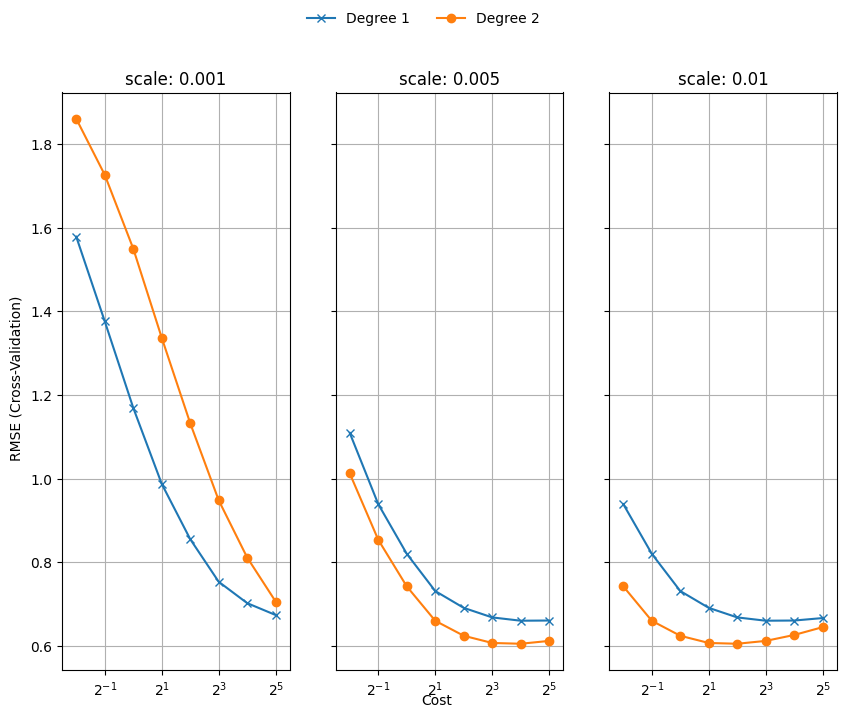

In [20]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, sharey=True)

line1, = ax1.plot(np.logspace(-2, 5, num=8, base=2), getRMSE(0.001, 1), '-x')
line2, = ax1.plot(np.logspace(-2, 5, num=8, base=2), getRMSE(0.001, 2), '-o')
ax1.set_xscale('log', base=2)
ax1.set_xlim(2**-2.5, 2**5.5)
ax1.set_title('scale: 0.001')

ax2.plot(np.logspace(-2, 5, num=8, base=2), getRMSE(0.005, 1), '-x')
ax2.plot(np.logspace(-2, 5, num=8, base=2), getRMSE(0.005, 2), '-o')
ax2.set_xscale('log', base=2)
ax2.set_xlim(2**-2.5, 2**5.5)
ax2.set_title('scale: 0.005')

ax3.plot(np.logspace(-2, 5, num=8, base=2), getRMSE(0.01, 1), '-x')
ax3.plot(np.logspace(-2, 5, num=8, base=2), getRMSE(0.01, 2), '-o')
ax3.set_xscale('log', base=2)
ax3.set_xlim(2**-2.5, 2**5.5)
ax3.set_title('scale: 0.01')

fig.legend([line1, line2], ('Degree 1', 'Degree 2'), loc='upper center', ncol=2, frameon=False)
fig.text(0.08, 0.5, 'RMSE (Cross-Validation)', ha='center', va='center', rotation=90)
fig.text(0.5, 0.07, 'Cost', ha='center', va='center')

### 3. K-Nearest Neighbors

In [21]:
cv

ShuffleSplit(n_splits=10, random_state=3, test_size=0.1, train_size=None)

In [22]:
from sklearn.neighbors import KNeighborsRegressor

knnreg = KNeighborsRegressor()

knn_params = {
    'n_neighbors': np.arange(1, 21, 1)
}
gs_knnreg = GridSearchCV(knnreg, knn_params, cv=cv, scoring='neg_mean_squared_error', n_jobs=-1)
gs_knnreg.fit(trainX, trainY)

GridSearchCV(cv=ShuffleSplit(n_splits=10, random_state=3, test_size=0.1, train_size=None),
             estimator=KNeighborsRegressor(), n_jobs=-1,
             param_grid={'n_neighbors': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20])},
             scoring='neg_mean_squared_error')

In [23]:
gs_knnreg_rmse = np.sqrt(-gs_knnreg.cv_results_['mean_test_score'])

Text(0, 0.5, 'RMSE (Cross-Validation)')

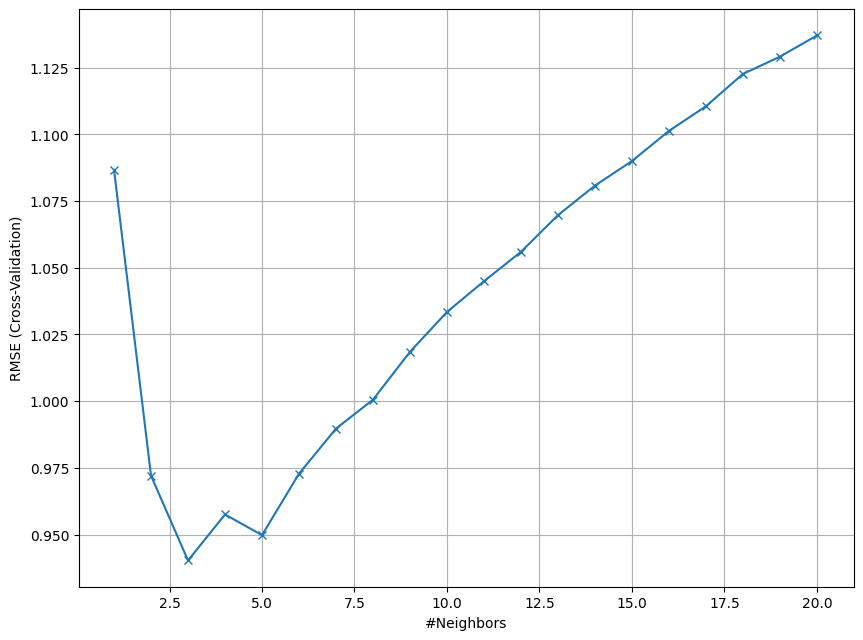

In [24]:
plt.plot(np.arange(1, 21, 1), gs_knnreg_rmse, '-x')
plt.xlim(None, 21)
plt.xlabel('#Neighbors')
plt.ylabel('RMSE (Cross-Validation)')